In [54]:
!pip install scipy


In [55]:
from scipy.io import loadmat
data = loadmat("China_Change_Dataset.mat")
print(data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'Multiple', 'T1', 'T2', 'Binary'])


In [56]:
for key in data:
    if not key.startswith("__"):  
        print(f"Key: {key}")
        print(f"Type: {type(data[key])}")
        print(f"First few values:\n{data[key][:5]}\n")  # Display first 5 elements


Key: Multiple
Type: <class 'numpy.ndarray'>
First few values:
[[[  0   0 254]
  [  0   0 254]
  [  0   0 254]
  ...
  [  0   0 254]
  [  0   0 254]
  [  0   0 254]]

 [[  0   0 254]
  [  0   0 254]
  [  0   0 254]
  ...
  [  0   0 254]
  [  0   0 254]
  [  0   0 254]]

 [[  0   0 254]
  [  0   0 254]
  [  0   0 254]
  ...
  [  0   0 254]
  [  0   0 254]
  [  0   0 254]]

 [[  0   0 254]
  [  0   0 254]
  [  0   0 254]
  ...
  [  0   0 254]
  [  0   0 254]
  [  0   0 254]]

 [[  0   0 254]
  [  0   0 254]
  [  0   0 254]
  ...
  [  0   0 254]
  [  0   0 254]
  [  0   0 254]]]

Key: T1
Type: <class 'numpy.ndarray'>
First few values:
[[[ 294   80  182 ... 1395 1415 1475]
  [ 329  134  242 ... 1560 1607 1686]
  [ 323  143  240 ... 1395 1607 1586]
  ...
  [ 282   81  170 ... 1343 1580 1582]
  [ 299  102  191 ... 1614 1682 1783]
  [ 316  115  209 ... 1391 1512 1549]]

 [[ 316  134  208 ... 1521 1257 1252]
  [ 318  116  189 ... 1424 1166 1174]
  [ 316  114  218 ... 1521 1460 1519]
  ...
  [ 2

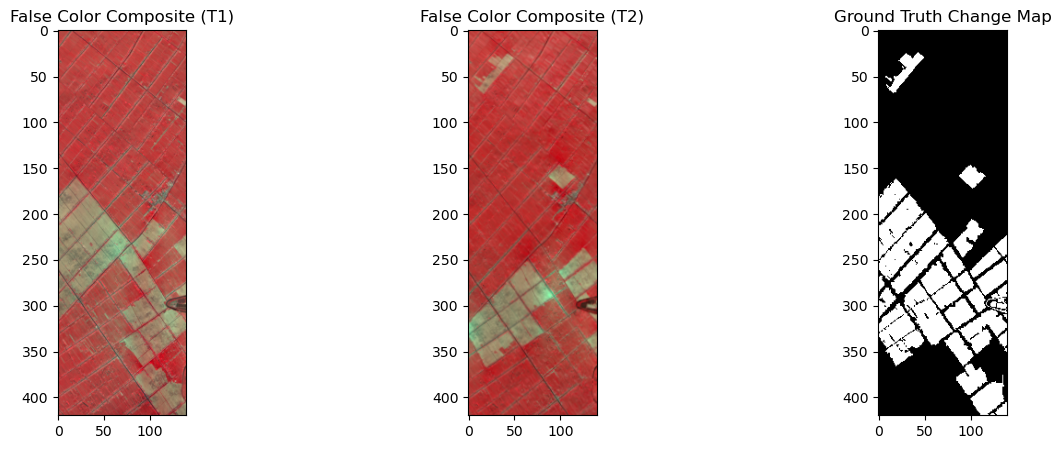

In [57]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
data = sio.loadmat("China_Change_Dataset.mat")
T1 = data["T1"]  
T2 = data["T2"] 
GT = data["Binary"] 
no_trian_samples=50000
def create_false_color(image, bands=[30, 20, 10]):
    false_color = np.dstack([image[:, :, b] for b in bands])
    false_color = (false_color - false_color.min()) / (false_color.max() - false_color.min())
    return false_color

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(create_false_color(T1))
plt.title("False Color Composite (T1)")

plt.subplot(1, 3, 2)
plt.imshow(create_false_color(T2))
plt.title("False Color Composite (T2)")

plt.subplot(1, 3, 3)
plt.imshow(GT, cmap="gray")
plt.title("Ground Truth Change Map")

plt.show()


Total number of samples (pixels): 58800
Number of features available per sample: 154
Number of features after PCA: 60
Number of training samples used: 1000


/home/nithin/miniconda3/envs/it464/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:07:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


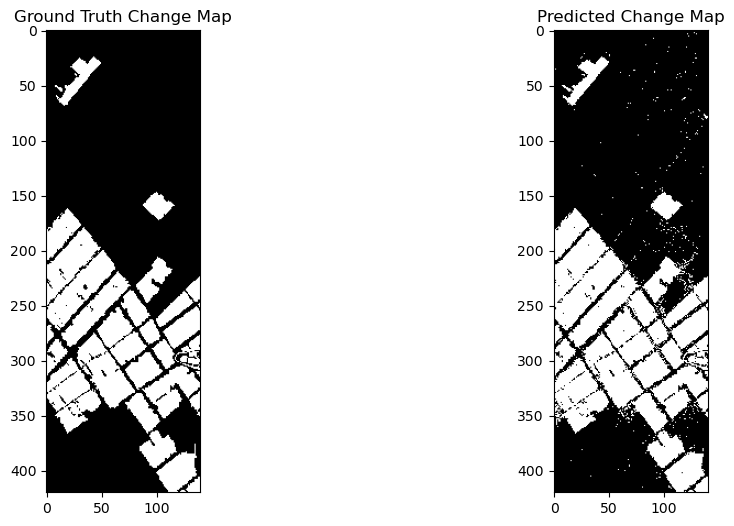

Confusion Matrix:
[[38964  1453]
 [   69 18314]]
Model Accuracy: 97.41%


In [58]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import shuffle
data = sio.loadmat("China_Change_Dataset.mat")

T1 = data["T1"] 
T2 = data["T2"]  
GT = data["Binary"]  


height, width, num_bands = T1.shape

X1 = T1.reshape(-1, num_bands)
X2 = T2.reshape(-1, num_bands)

X_diff = np.abs(X2 - X1)

y = GT.ravel()

print(f"Total number of samples (pixels): {X_diff.shape[0]}")
print(f"Number of features available per sample: {num_bands}")
no_train_samples=1000
idx_change = np.where(y == 1)[0]
idx_nochange = np.where(y == 0)[0]
num_samples = min(no_trian_samples, len(idx_change), len(idx_nochange))
idx_sample = np.concatenate([
    np.random.choice(idx_change, num_samples, replace=False),
    np.random.choice(idx_nochange, num_samples, replace=False)
])

X_train = X_diff[idx_sample]
y_train = y[idx_sample]
X_train, y_train = shuffle(X_train, y_train, random_state=42)

pca_components = 60  
pca = PCA(n_components=pca_components)
X_train_pca = pca.fit_transform(X_train)
X_diff_pca = pca.transform(X_diff)


print(f"Number of features after PCA: {pca_components}")
print(f"Number of training samples used: {1000}")
model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_pca, y_train)


y_pred = model.predict(X_diff_pca)

pred_map = y_pred.reshape(height, width)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(GT, cmap="gray")
plt.title("Ground Truth Change Map")
plt.subplot(1, 2, 2)
plt.imshow(pred_map, cmap="gray")
plt.title("Predicted Change Map")
plt.show()

cm = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)
print("Confusion Matrix:")
print(cm)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Precision: 0.93
Recall: 1.00


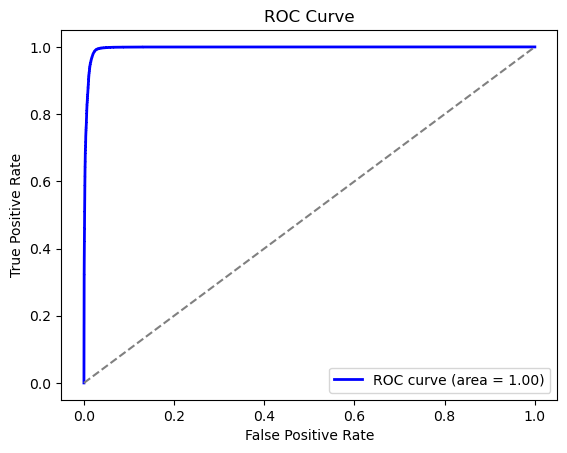

In [59]:
from sklearn.metrics import precision_score, recall_score, roc_curve, auc

precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

fpr, tpr, _ = roc_curve(y, model.predict_proba(X_diff_pca)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
